Description:
- absolute state
- states dimension is 6
- one target and one obstacle

---
Function: 
> This codes will create a new knowledge which is helpful for the design of logic controller.

In [1]:
import numpy as np
from scipy.linalg import expm
import random

class move_gym():
    def __init__(self):
        self.scope = 2.0
        self.states = 6
        self.actions = 4
    def reset(self):

        self.obstacle_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.obstacle_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1

        self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1  
        while ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 ):
            self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1      

        self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        while (  ( abs(self.obstacle_x-self.target_x) < 1.05 ) & ( abs(self.obstacle_y-self.target_y) < 1.05 )  ) |\
         (  ( abs(self.move_x-self.target_x) < 1.05 ) & ( abs(self.move_y-self.target_y) < 1.05 )  ):
            self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1        


        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])
        return state #, self.state2img(state)
    def step(self, action):
        velocity = 0.2
        if action==0: # up down right left
            self.move_y+=velocity
        if action==1:
            self.move_y-=velocity
        if action==2:
            self.move_x+=velocity
        if action==3:
            self.move_x-=velocity

        if self.move_x > (self.scope+1.0):
            self.move_x-=velocity
        if self.move_x < (-self.scope-1.0):
            self.move_x+=velocity
        if self.move_y > (self.scope+1.0):
            self.move_y-=velocity
        if self.move_y < (-self.scope-1.0):
            self.move_y+=velocity
        
        reward = -0.1
        done = False
        info = "^_^"
        if (  ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 )  ): 
            reward = -1.0 
            done = True
            info = "collision"

        elif (  ( abs(self.target_x-self.move_x) < 1.05 ) & ( abs(self.target_y-self.move_y) < 1.05 )  ):
            reward = 1.0
            done = True
            info = "reach"

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])

        return state, reward,done,info
    def state2img(self, state):
        img = np.zeros([84,84,3], dtype=np.uint8)
        ( img[ int(42-(self.obstacle_y+0.5)*10):int(42-(self.obstacle_y-0.5)*10), int((self.obstacle_x-0.5)*10+42):int((self.obstacle_x+0.5)*10+42),2 ] ).fill(255)
        ( img[ int(42-(self.target_y+0.5)*10):int(42-(self.target_y-0.5)*10), int((self.target_x-0.5)*10+42):int((self.target_x+0.5)*10+42),1 ] ).fill(255)
        ( img[ int(42-(self.move_y+0.5)*10):int(42-(self.move_y-0.5)*10), int((self.move_x-0.5)*10+42):int((self.move_x+0.5)*10+42),0 ] ).fill(255)
        return img

In [2]:
import tensorflow as tf
import numpy as np
from numpy import *
import random
from collections import deque

from tqdm import trange

# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
    # DQN Agent
    def __init__(self, env):
        # init experience replay
        self.replay_buffer = deque()
        # init. some parameters
        self.epsilon = INITIAL_EPSILON
        # self.state_dim = env.observation_space.shape[0]
        self.state_dim = env.states

        # self.action_dim = env.action_space.n
        self.action_dim = env.actions

        self.create_Q_network()
        self.create_training_method()

        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())

    def create_Q_network(self):
        # # a: create new network weights
        print "create new network weights ..."
        num_hid = 200
        self.W1 = self.weight_variable([self.state_dim,num_hid])
        self.b1 = self.bias_variable([num_hid])
        self.W2 = self.weight_variable([num_hid,num_hid])
        self.b2 = self.bias_variable([num_hid])
        self.W3 = self.weight_variable([num_hid,self.action_dim])
        self.b3= self.bias_variable([self.action_dim])

        # # # b: restore old network weights
        # print "restore old network weights ..."
        # self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = self.restore_wb()


        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input,self.W1) + self.b1)
        h_layer02 = tf.nn.relu(tf.matmul(h_layer,self.W2) + self.b2)
        # Q Value layer
        self.Q_value = tf.matmul(h_layer02,self.W3) + self.b3

    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def train_Q_network(self):
        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        # Step 2: calculate y
        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i])
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={
          self.y_input:y_batch,
          self.action_input:action_batch,
          self.state_input:state_batch
          })

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0]
        if random.random() < 0.5:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)

    def obtain_wb(self):
        W1=self.session.run(self.W1)
        b1=self.session.run(self.b1)
        W2=self.session.run(self.W2)
        b2=self.session.run(self.b2)
        W3=self.session.run(self.W3)
        b3=self.session.run(self.b3)
        return W1, b1, W2, b2, W3, b3

    def restore_wb(self):
        W1 = np.load( "W1.npy" )
        W2 = np.load( "W2.npy" )
        W3 = np.load( "W3.npy" )

        b1 = np.load( "b1.npy" )
        b2 = np.load( "b2.npy" )
        b3 = np.load( "b3.npy" )        
        return tf.Variable(W1), tf.Variable(b1), tf.Variable(W2), tf.Variable(b2), tf.Variable(W3), tf.Variable(b3)
    def use_nn(self,state):
        return self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })

    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0])

    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)
    
    
# Hyper Parameters
STEP = 50 # Step limitation in an episode
TEST = 10 # The number of experiment for test

# initialize env and agent
env = move_gym()
agent = DQN(env)

all_episode = 0
all_reward = []

create new network weights ...


In [30]:
EPISODE = 5*10000
all_episode += EPISODE
for episode in trange(EPISODE):

    # Train
    state = env.reset()
    for step in xrange(STEP):
        action = agent.egreedy_action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        agent.perceive(state,action,reward,next_state,done)
        state = next_state
        if done:
            break

    # Test
    if (episode % 100) == 0:
        total_reward = 0
        for i in xrange(TEST):
            state = env.reset()
            for j in xrange(STEP):
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        
        all_reward.append( ave_reward )
        if (episode % (EPISODE//100)) == 0:
            print 'episode: ',episode,'Evaluation Average Reward:',ave_reward

  0%|          | 2/50000 [00:00<51:16, 16.25it/s]

episode:  0 Evaluation Average Reward: 0.34


  1%|          | 502/50000 [00:45<1:15:45, 10.89it/s]

episode:  500 Evaluation Average Reward: -0.01


  2%|▏         | 1002/50000 [01:31<1:05:40, 12.44it/s]

episode:  1000 Evaluation Average Reward: 0.31


  3%|▎         | 1505/50000 [02:14<1:04:49, 12.47it/s]

episode:  1500 Evaluation Average Reward: 0.03


  4%|▍         | 2002/50000 [03:00<1:23:46,  9.55it/s]

episode:  2000 Evaluation Average Reward: 0.21


  5%|▌         | 2502/50000 [03:45<1:16:31, 10.34it/s]

episode:  2500 Evaluation Average Reward: 0.57


  6%|▌         | 3001/50000 [04:29<1:18:59,  9.92it/s]

episode:  3000 Evaluation Average Reward: 0.28


  7%|▋         | 3502/50000 [05:15<1:31:03,  8.51it/s]

episode:  3500 Evaluation Average Reward: 0.5


  8%|▊         | 4001/50000 [06:00<1:21:51,  9.37it/s]

episode:  4000 Evaluation Average Reward: 0.4


  9%|▉         | 4501/50000 [06:47<58:42, 12.92it/s]  

episode:  4500 Evaluation Average Reward: 0.28


 10%|█         | 5004/50000 [07:36<58:10, 12.89it/s]  

episode:  5000 Evaluation Average Reward: 0.39


 11%|█         | 5501/50000 [08:26<1:28:14,  8.41it/s]

episode:  5500 Evaluation Average Reward: 0.19


 12%|█▏        | 6003/50000 [09:14<1:32:01,  7.97it/s]

episode:  6000 Evaluation Average Reward: 0.43


 13%|█▎        | 6503/50000 [10:03<1:24:48,  8.55it/s]

episode:  6500 Evaluation Average Reward: 0.58


 14%|█▍        | 7001/50000 [10:48<1:02:51, 11.40it/s]

episode:  7000 Evaluation Average Reward: -0.34


 15%|█▌        | 7503/50000 [11:39<1:11:37,  9.89it/s]

episode:  7500 Evaluation Average Reward: -0.31


 16%|█▌        | 8003/50000 [12:25<1:22:29,  8.48it/s]

episode:  8000 Evaluation Average Reward: 0.24


 17%|█▋        | 8502/50000 [13:13<1:27:54,  7.87it/s]

episode:  8500 Evaluation Average Reward: 0.4


 18%|█▊        | 9002/50000 [14:00<53:17, 12.82it/s]  

episode:  9000 Evaluation Average Reward: 0.14


 19%|█▉        | 9502/50000 [14:47<1:30:15,  7.48it/s]

episode:  9500 Evaluation Average Reward: 0.6


 20%|██        | 10001/50000 [15:37<1:16:00,  8.77it/s]

episode:  10000 Evaluation Average Reward: 0.41


 21%|██        | 10501/50000 [16:25<1:17:13,  8.53it/s]

episode:  10500 Evaluation Average Reward: 0.33


 22%|██▏       | 11003/50000 [17:13<1:03:44, 10.20it/s]

episode:  11000 Evaluation Average Reward: 0.52


 23%|██▎       | 11500/50000 [18:00<45:51, 13.99it/s]  

episode:  11500 Evaluation Average Reward: 0.28


 24%|██▍       | 12002/50000 [18:45<1:37:14,  6.51it/s]

episode:  12000 Evaluation Average Reward: 0.45


 25%|██▌       | 12500/50000 [19:28<51:30, 12.13it/s]  

episode:  12500 Evaluation Average Reward: 0.25


 26%|██▌       | 13001/50000 [20:10<1:08:26,  9.01it/s]

episode:  13000 Evaluation Average Reward: -0.4


 27%|██▋       | 13503/50000 [20:58<50:07, 12.13it/s]  

episode:  13500 Evaluation Average Reward: -0.11


 28%|██▊       | 14002/50000 [21:42<51:32, 11.64it/s]  

episode:  14000 Evaluation Average Reward: 0.44


 29%|██▉       | 14501/50000 [22:29<56:00, 10.56it/s]  

episode:  14500 Evaluation Average Reward: 0.24


 30%|███       | 15002/50000 [23:14<50:44, 11.50it/s]  

episode:  15000 Evaluation Average Reward: 0.26


 31%|███       | 15501/50000 [23:59<50:55, 11.29it/s]  

episode:  15500 Evaluation Average Reward: 0.4


 32%|███▏      | 16000/50000 [24:46<56:18, 10.06it/s]  

episode:  16000 Evaluation Average Reward: 0.31


 33%|███▎      | 16503/50000 [25:27<48:22, 11.54it/s]  

episode:  16500 Evaluation Average Reward: 0.3


 34%|███▍      | 17002/50000 [26:12<1:19:00,  6.96it/s]

episode:  17000 Evaluation Average Reward: 0.1


 35%|███▌      | 17500/50000 [26:58<53:23, 10.14it/s]  

episode:  17500 Evaluation Average Reward: -0.24


 36%|███▌      | 18001/50000 [27:47<53:04, 10.05it/s]  

episode:  18000 Evaluation Average Reward: 0.39


 37%|███▋      | 18502/50000 [28:37<52:55,  9.92it/s]  

episode:  18500 Evaluation Average Reward: -0.36


 38%|███▊      | 19002/50000 [29:25<51:15, 10.08it/s]  

episode:  19000 Evaluation Average Reward: 0.36


 39%|███▉      | 19501/50000 [30:12<1:02:01,  8.20it/s]

episode:  19500 Evaluation Average Reward: 0.12


 40%|████      | 20003/50000 [31:01<1:00:19,  8.29it/s]

episode:  20000 Evaluation Average Reward: 0.45


 41%|████      | 20502/50000 [31:50<46:47, 10.51it/s]  

episode:  20500 Evaluation Average Reward: 0.44


 42%|████▏     | 21002/50000 [32:35<47:00, 10.28it/s]  

episode:  21000 Evaluation Average Reward: 0.25


 43%|████▎     | 21501/50000 [33:22<51:05,  9.30it/s]  

episode:  21500 Evaluation Average Reward: 0.39


 44%|████▍     | 22001/50000 [34:09<55:53,  8.35it/s]  

episode:  22000 Evaluation Average Reward: 0.56


 45%|████▌     | 22503/50000 [34:56<1:04:00,  7.16it/s]

episode:  22500 Evaluation Average Reward: -0.23


 46%|████▌     | 23000/50000 [35:42<40:39, 11.07it/s]  

episode:  23000 Evaluation Average Reward: 0.36


 47%|████▋     | 23503/50000 [36:30<25:11, 17.53it/s]  

episode:  23500 Evaluation Average Reward: -0.07


 48%|████▊     | 24002/50000 [37:17<1:02:01,  6.99it/s]

episode:  24000 Evaluation Average Reward: 0.31


 49%|████▉     | 24501/50000 [38:04<1:02:50,  6.76it/s]

episode:  24500 Evaluation Average Reward: 0.2


 50%|█████     | 25003/50000 [38:49<44:03,  9.46it/s]  

episode:  25000 Evaluation Average Reward: -0.43


 51%|█████     | 25501/50000 [39:38<34:14, 11.93it/s]  

episode:  25500 Evaluation Average Reward: 0.37


 52%|█████▏    | 26001/50000 [40:26<1:10:05,  5.71it/s]

episode:  26000 Evaluation Average Reward: 0.22


 53%|█████▎    | 26502/50000 [41:11<33:33, 11.67it/s]  

episode:  26500 Evaluation Average Reward: -0.05


 54%|█████▍    | 27002/50000 [41:58<32:44, 11.71it/s]  

episode:  27000 Evaluation Average Reward: 0.76


 55%|█████▌    | 27502/50000 [42:45<26:07, 14.35it/s]  

episode:  27500 Evaluation Average Reward: 0.52


 56%|█████▌    | 28003/50000 [43:31<25:39, 14.29it/s]

episode:  28000 Evaluation Average Reward: 0.4


 57%|█████▋    | 28502/50000 [44:18<47:19,  7.57it/s]  

episode:  28500 Evaluation Average Reward: -0.14


 58%|█████▊    | 29000/50000 [45:03<33:57, 10.31it/s]

episode:  29000 Evaluation Average Reward: 0.31


 59%|█████▉    | 29498/50000 [45:46<44:39,  7.65it/s]

episode:  29500 Evaluation Average Reward: 0.33


 60%|██████    | 30002/50000 [46:33<31:32, 10.57it/s]  

episode:  30000 Evaluation Average Reward: 0.14


 61%|██████    | 30503/50000 [47:21<35:17,  9.21it/s]

episode:  30500 Evaluation Average Reward: 0.3


 62%|██████▏   | 31003/50000 [48:07<25:30, 12.41it/s]  

episode:  31000 Evaluation Average Reward: 0.4


 63%|██████▎   | 31503/50000 [48:56<28:31, 10.81it/s]

episode:  31500 Evaluation Average Reward: 0.18


 64%|██████▍   | 32003/50000 [49:42<27:21, 10.96it/s]

episode:  32000 Evaluation Average Reward: 0.25


 65%|██████▌   | 32505/50000 [50:28<23:41, 12.31it/s]

episode:  32500 Evaluation Average Reward: 0.45


 66%|██████▌   | 33002/50000 [51:12<22:20, 12.68it/s]

episode:  33000 Evaluation Average Reward: 0.26


 67%|██████▋   | 33503/50000 [52:01<27:26, 10.02it/s]

episode:  33500 Evaluation Average Reward: 0.13


 68%|██████▊   | 34002/50000 [52:46<33:17,  8.01it/s]

episode:  34000 Evaluation Average Reward: 0.34


 69%|██████▉   | 34501/50000 [53:34<27:43,  9.32it/s]

episode:  34500 Evaluation Average Reward: -0.38


 70%|███████   | 35004/50000 [54:20<19:39, 12.71it/s]

episode:  35000 Evaluation Average Reward: 0.36


 71%|███████   | 35504/50000 [55:05<25:07,  9.62it/s]

episode:  35500 Evaluation Average Reward: -0.23


 72%|███████▏  | 36002/50000 [55:53<22:09, 10.52it/s]

episode:  36000 Evaluation Average Reward: 0.17


 73%|███████▎  | 36501/50000 [56:37<14:57, 15.04it/s]

episode:  36500 Evaluation Average Reward: 0.39


 74%|███████▍  | 37003/50000 [57:26<20:41, 10.47it/s]

episode:  37000 Evaluation Average Reward: 0.05


 75%|███████▌  | 37502/50000 [58:13<17:45, 11.73it/s]

episode:  37500 Evaluation Average Reward: 0.27


 76%|███████▌  | 38002/50000 [58:59<16:31, 12.10it/s]

episode:  38000 Evaluation Average Reward: 0.49


 77%|███████▋  | 38502/50000 [59:46<23:09,  8.28it/s]

episode:  38500 Evaluation Average Reward: 0.36


 78%|███████▊  | 39001/50000 [1:00:33<24:18,  7.54it/s]

episode:  39000 Evaluation Average Reward: 0.21


 79%|███████▉  | 39500/50000 [1:01:19<14:06, 12.40it/s]

episode:  39500 Evaluation Average Reward: 0.23


 80%|████████  | 40001/50000 [1:02:07<14:09, 11.77it/s]

episode:  40000 Evaluation Average Reward: -0.05


 81%|████████  | 40504/50000 [1:02:54<14:47, 10.70it/s]

episode:  40500 Evaluation Average Reward: 0.36


 82%|████████▏ | 41001/50000 [1:03:42<19:21,  7.75it/s]

episode:  41000 Evaluation Average Reward: 0.38


 83%|████████▎ | 41503/50000 [1:04:29<11:59, 11.82it/s]

episode:  41500 Evaluation Average Reward: 0.36


 84%|████████▍ | 42002/50000 [1:05:15<14:36,  9.12it/s]

episode:  42000 Evaluation Average Reward: 0.51


 85%|████████▌ | 42500/50000 [1:06:02<11:46, 10.61it/s]

episode:  42500 Evaluation Average Reward: 0.34


 86%|████████▌ | 43001/50000 [1:06:49<12:28,  9.35it/s]

episode:  43000 Evaluation Average Reward: 0.39


 87%|████████▋ | 43503/50000 [1:07:35<10:57,  9.88it/s]

episode:  43500 Evaluation Average Reward: 0.32


 88%|████████▊ | 44004/50000 [1:08:22<10:02,  9.95it/s]

episode:  44000 Evaluation Average Reward: 0.19


 89%|████████▉ | 44505/50000 [1:09:06<07:50, 11.68it/s]

episode:  44500 Evaluation Average Reward: 0.48


 90%|█████████ | 45003/50000 [1:09:50<07:42, 10.81it/s]

episode:  45000 Evaluation Average Reward: 0.51


 91%|█████████ | 45502/50000 [1:10:37<07:59,  9.37it/s]

episode:  45500 Evaluation Average Reward: -0.23


 92%|█████████▏| 46002/50000 [1:11:24<07:38,  8.73it/s]

episode:  46000 Evaluation Average Reward: 0.37


 93%|█████████▎| 46502/50000 [1:12:13<07:01,  8.30it/s]

episode:  46500 Evaluation Average Reward: -0.06


 94%|█████████▍| 47002/50000 [1:12:55<05:09,  9.69it/s]

episode:  47000 Evaluation Average Reward: -0.16


 95%|█████████▌| 47502/50000 [1:13:36<04:08, 10.03it/s]

episode:  47500 Evaluation Average Reward: -0.07


 96%|█████████▌| 48002/50000 [1:14:20<02:32, 13.14it/s]

episode:  48000 Evaluation Average Reward: 0.41


 97%|█████████▋| 48502/50000 [1:15:02<02:55,  8.53it/s]

episode:  48500 Evaluation Average Reward: -0.27


 98%|█████████▊| 49001/50000 [1:15:43<01:25, 11.69it/s]

episode:  49000 Evaluation Average Reward: 0.48


 99%|█████████▉| 49505/50000 [1:16:22<00:40, 12.19it/s]

episode:  49500 Evaluation Average Reward: 0.65


100%|██████████| 50000/50000 [1:17:02<00:00, 10.82it/s]


In [31]:
print all_episode, len(all_reward)

400000 4000


In [32]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

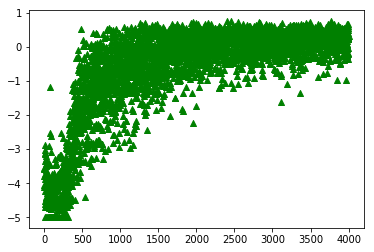

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
# ax.set_xlim(0.5, 4.5)
plt.show()

In [44]:
mean_reward=[]
for i in xrange(3500):
    mean_reward.append( mean(all_reward[i:i+100]) )

In [46]:
max_reward=[]
for i in xrange(3500):
    max_reward.append( max(all_reward[i:i+100]) )

In [56]:
min_reward=[]
for i in xrange(3500):
    min_reward.append( min(all_reward[i:i+100]) )

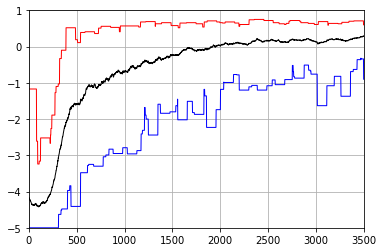

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(mean_reward)), mean_reward, color='black', linewidth=1) # plot line
ax.plot(range(len(max_reward)), max_reward, color='red', linewidth=1) # plot line
ax.plot(range(len(min_reward)), min_reward, color='blue', linewidth=1) # plot line
ax.set_ylim(-5, 1)
ax.set_xlim(0, 3500)
plt.grid(True)
plt.show()

> Check

In [53]:
reach = 0
collision = 0
for i in trange(3000):

    state = env.reset()
    for j in xrange(STEP):
        action = agent.action(state) # direct action for test
        state,reward,done,info = env.step(action)
        total_reward += reward
        if done:
#             print info

            if info == "reach":
                reach += 1
            if info == "collision":
                collision += 1

            break
print "reach: ", reach, "collision: ", collision

100%|██████████| 3000/3000 [00:11<00:00, 252.29it/s]

reach:  2942 collision:  15


- The result of checking is not bad
- even we might improve the network with oversampling
- now we focus the design of logic controller

In [28]:
W1, b1, W2, b2, W3, b3 = agent.obtain_wb()

In [29]:
np.save('W1', W1)
np.save('W2', W2)
np.save('W3', W3)

np.save('b1', b1)
np.save('b2', b2)
np.save('b3', b3)